In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ReactionDiffusion, HomogeneousReactionDiffusion
from lafomo.models import NeuralOperator, RecurrentNeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import plot_spatiotemporal_data, tight_kwargs, Plotter2d

torch.Size([41, 41, 3])


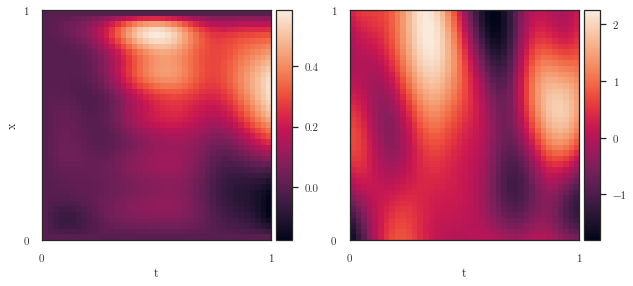

In [2]:
ntest = 50

dataset = ReactionDiffusion('../../../data',
                            nn_format=True,
                            max_n=4000,
                            ntest=ntest,
                            sub=1)

def convert_2d_to_1d_rnn(data, time_dim=0):
    perm = list(range(data[0][0].ndim))
    del perm[time_dim]
    perm += [time_dim]
    for i in range(len(data)):
        data[i] = (
            data[i][0].permute(perm)[..., 0],
            data[i][1],
            data[i][2]
        )
    print(data[0][0].shape)

i = 3
tx = dataset.data[i][0]
lf = dataset.data[i][1]
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [
        tx[:, :, 0].t(),
        lf[:, :, 0].t(),
    ],
    extent, nrows=1, ncols=2
)
print(dataset.train_data[0][0].shape)
# convert_2d_to_1d_rnn(dataset.train_data, time_dim=1)

batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


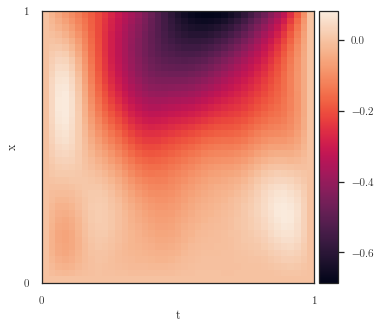

In [3]:
dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=False)

dataset = HomogeneousReactionDiffusion('../../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=False)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 1
learning_rate = 1e-3

modes = 10
width = 38
in_channels = 3


In [4]:
model = RecurrentNeuralOperator(
    block_dim, in_channels, 2, modes, width, num_layers=4)

print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)
print(train_loader.dataset[0][0].shape)

229733
torch.Size([41, 41, 3])


torch.Size([41, 41, 3])


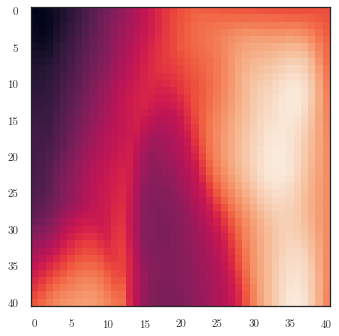

In [5]:
x, y, p = next(iter(train_loader))
print(x[0].shape)
a = model(x)
plt.imshow(a[0, ..., 0].detach())

In [6]:
# state_dict = torch.load('../nn/saved_model1505.pt')

In [7]:
trainer.train(10);
s

Epoch 001/010 - Loss: 1.36 (1.29 1.36 1.29 0.00 0.00)
Epoch 002/010 - Loss: 1.23 (1.23 1.23 1.23 0.00 0.00)
Epoch 003/010 - Loss: 1.19 (1.20 1.19 1.20 0.00 0.00)
Epoch 004/010 - Loss: 1.17 (1.17 1.17 1.17 0.00 0.00)
Epoch 005/010 - Loss: 1.15 (1.15 1.15 1.15 0.00 0.00)
Epoch 006/010 - Loss: 1.14 (1.15 1.14 1.15 0.00 0.00)
Epoch 007/010 - Loss: 1.13 (1.13 1.13 1.13 0.00 0.00)
Epoch 008/010 - Loss: 1.12 (1.12 1.12 1.12 0.00 0.00)
Epoch 009/010 - Loss: 1.11 (1.12 1.11 1.12 0.00 0.00)
Epoch 010/010 - Loss: 1.11 (1.12 1.11 1.12 0.00 0.00)


NameError: name 's' is not defined

In [8]:
from torch.nn.functional import softplus
from torch.distributions import Normal
def show_result(model, loader, plot_uncertainty=False, plotter=None, index=0):
    x, y, params = next(iter(loader))
    y_pred = model(x)
    # p_y_pred = model.predict_f(x)
    if model.params:
        p_y_pred, params_out = y_pred
    p_y_mean = y_pred[..., 0]
    p_y_var = softplus(y_pred[..., 1])
    p_y_pred = Normal(p_y_mean, p_y_var)

    mean = p_y_pred.mean[index]
    std  = p_y_pred.variance.sqrt()[index]
    num_t = x.shape[1]
    num_x = x.shape[2]
    x = x[index][...,0]
    y = y[index]
    if not plot_uncertainty:
        plot_spatiotemporal_data(
            [
                mean.detach().view(num_t, num_x).t(),
                y.view(num_t, num_x).t(), #num_t
                x.view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input'],
            cticks=None,  # [0, 100, 200]
            clim=[(y.min(), y.max())] * 2 + [(x.min(), x.max())],
        )
    else:
        a = np.zeros((41, 41, 4))
        a[:, :, 0] = mean
        a[:, :, 0] = (a[:, :, 0] - a[:, :, 0].min()) / (a[:, :, 0].max() - a[:, :, 0].min())
        a[:, :, 3] = std
        a[:, :, 3] = 1-(a[:, :, 3] - a[:, :, 3].min()) / (a[:, :, 3].max() - a[:, :, 3].min())
        plt.imshow(a, origin='lower', extent=extent)
        plt.colorbar()

    plotter.plot_double_bar(
        params_out[0:1],
        ['l1', 'l2', 'sens', 'decay', 'diff'],
        ground_truths=params[0:1],
        figsize=(5, 3)
    )
    out = mean.squeeze()
    y_target = y.squeeze()

    print(params_out[0].detach(), params[0])
    print(F.mse_loss(out, y_target))
    # from lafomo.utilities.torch import smse, q2
    # print(y.shape, f_mean_test.shape)
    # print(smse(y_target, f_mean_test).shape)

UnboundLocalError: local variable 'params_out' referenced before assignment

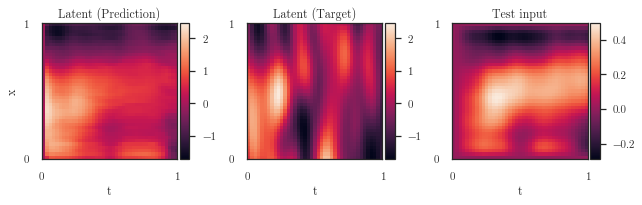

In [10]:
model.num_outputs = 1
plotter = Plotter2d(model, np.array(['']))

show_result(model, test_loader, plotter=plotter)

In [ ]:
i = 10
show_result(model, subsampled_loader, plotter=plotter, index=i)
show_result(model, high_res_loader, plotter=plotter, index=i)

In [ ]:
print(trainer.data_loader.dataset.__len__())

In [ ]:
from lafomo.datasets import DrosophilaSpatialTranscriptomics
from scipy.interpolate import interp1d

weird = True
if weird:
    from lafomo.utilities.data import generate_neural_dataset_2d
    temp = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data', scale=True, scale_tx=True, nn_format=False)
    params = torch.tensor([-1.]*5).unsqueeze(0)
    train, test = generate_neural_dataset_2d(temp.orig_data.unsqueeze(0), params, 1, 0)
    train[0][0][..., 0] /= 6
    print('train', train[0][0][..., 0].shape)
    class Fuckery():
        def __init__(self):
            self.train_data = train
    dataset = Fuckery()
else:
    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data', scale=True, scale_tx=True, nn_format=True)


x = interp1d(np.linspace(0, 1, 8), dataset.train_data[0][0], axis=0)(np.linspace(0, 1, 64))
x1 = interp1d(np.linspace(0, 1, 8), dataset.train_data[0][1], axis=0)(np.linspace(0, 1, 64))
dataset.train_data[0] = (
    torch.tensor(x, dtype=torch.float32),#dataset.train_data[0][0],#.permute(1, 0, 2),
    torch.tensor(x1, dtype=torch.float32),
    dataset.train_data[0][2]
)

dros_loader = DataLoader(dataset.train_data)
show_result(model, dros_loader, plotter=plotter)

In [ ]:
# CALCULATING SMSE
import time

t0 = time.time()
x, y, params = next(iter(dros_loader))
p_y_pred, params_out = model.predict_f(x)
t1 = time.time()
mean = p_y_pred.mean[0]
std  = p_y_pred.variance.sqrt()[0]
y = y.squeeze()
from lafomo.utilities.torch import smse, q2
print(smse(y.view(-1), mean.view(-1)).mean())
print(q2(y.view(-1), mean.view(-1)).mean())
print(mean.shape, y.shape)
print(t1 - t0)

In [ ]:
torch.save(model.state_dict(), './saved_model1705.pt')

In [ ]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)

x_sub, y_sub, params_sub = subsampled_loader.dataset[i]
x, y, params = high_res_loader.dataset[i]
out, _ = model(x.unsqueeze(0))
out_sub, _ = model(x_sub.unsqueeze(0))

num_t = x.shape[0]
num_x = x.shape[1]
num_t_sub = x_sub.shape[0]
num_x_sub = x_sub.shape[1]

plot_spatiotemporal_data(
    [
        x[..., 0].view(num_t, num_x).t(),
        out_sub[0, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[0, ..., 0].detach().view(num_t, num_x).t(),
        y[..., 0].view(num_t, num_x).t(),
        # y_sub[..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[...,0].min(), x[...,0].max())] + [(out[0].min(), out[0].max())] * 3,
    titles=['Test input', 'Low-resolution Output', 'Super-resolution Output', 'Target Output']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
plt.savefig('toy48.pdf', **tight_kwargs)

In [ ]:
dataset = HomogeneousReactionDiffusion('../../../data', one_fixed_sample=True, nn_format=True, ntest=0)

toy_loader = DataLoader(dataset.train_data)
show_result(model, toy_loader)